Predict climate of a country (use all stations beginning with country code)

Get data for all given stations
Find monthly means
Plot these

In [17]:
import json
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

In [18]:
f = open('data/stat_counts_tmax.txt')
data = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [k for k, v in data.items() if v == 0]
station = no_gaps_tmax[0]
print(station)

GM000010147


In [19]:
ghn = GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

# Get list of station names
station_names = ghn.getStatKeyNames()

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(ghn.getStation(station))

t_max = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
dates = t_max.get_dates()
vals = t_max.get_vals()


Read 219 countries and codes
Read 991 stations with justGSN
Filename: GM000010147.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/GM000010147.dly
destination: data/GM000010147.dly
GM000010147 is HAMBURG FUHLSBUETTEL, Germany at 53.635 9.99 11.0


Text(0.5, 1.0, 'Mean monthly maximum temperatures over 10 years')

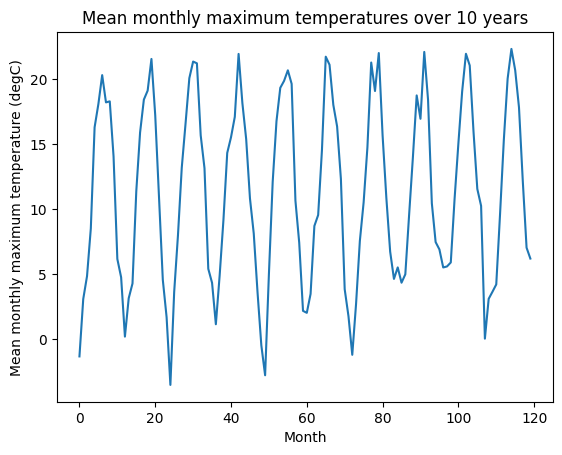

In [20]:
means = np.array(t_max.get_monthly_means())

fig, ax = plt.subplots()
ax.plot(means[:(12*10)])
ax.set_xlabel("Month")
ax.set_ylabel("Mean monthly maximum temperature (degC)")
ax.set_title("Mean monthly maximum temperatures over 10 years")

Text(0.5, 1.0, 'Mean monthly maximum temperatures over 10 years')

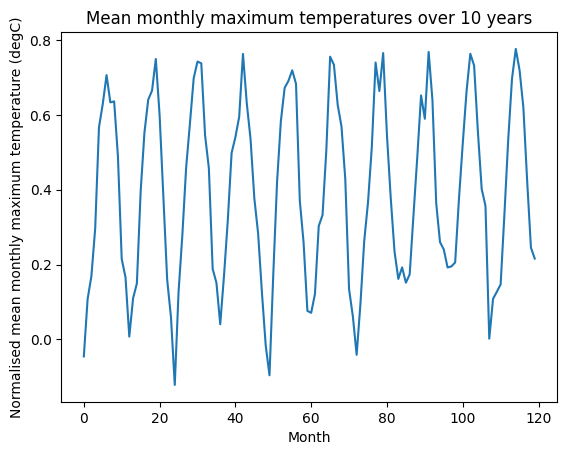

In [21]:
# normalise means: divide by the biggest value
means_normalised = t_max.normalise(means)

fig, ax = plt.subplots()
ax.plot(means_normalised[:(12*10)])
ax.set_xlabel("Month")
ax.set_ylabel("Normalised mean monthly maximum temperature (degC)")
ax.set_title("Mean monthly maximum temperatures over 10 years")

### Train model

In [22]:
WINDOW_SIZE = 10
OFFSET = 1

train_len = int(len(means_normalised) * 0.7)
validate_len = int(len(means_normalised) * 0.2)
test_len = int(len(means_normalised) * 0.1)

# divide data into training, validating and testing sets
means_train = means_normalised[test_len+1:test_len+train_len]
means_validate = means_normalised[test_len+train_len+1:]
means_test = means_normalised[:test_len]

# reshape data into input windows and targets
input_train, target_train = shapeArray(means_train, WINDOW_SIZE, OFFSET)
input_validate, target_validate = shapeArray(means_validate, WINDOW_SIZE, OFFSET)
input_test, target_test = shapeArray(means_test, WINDOW_SIZE, OFFSET)

print(f"Vals shape: {np.shape(vals)}")

print(f"Training input shape: {np.shape(input_train)}")
print(input_train[0:4])
print(f"Training target shape: {np.shape(target_train)}")
print(target_train[0:4])

Vals shape: (47390,)
Training input shape: (1078, 10)
[[0.07698551 0.14521739 0.23431884 0.42890555 0.55176812 0.65607196
  0.76602899 0.72347826 0.59814093 0.42121739]
 [0.14521739 0.23431884 0.42890555 0.55176812 0.65607196 0.76602899
  0.72347826 0.59814093 0.42121739 0.2507946 ]
 [0.23431884 0.42890555 0.55176812 0.65607196 0.76602899 0.72347826
  0.59814093 0.42121739 0.2507946  0.2146087 ]
 [0.42890555 0.55176812 0.65607196 0.76602899 0.72347826 0.59814093
  0.42121739 0.2507946  0.2146087  0.08985507]]
Training target shape: (1078,)
[0.2507946  0.2146087  0.08985507 0.17069243]


In [23]:
print(input_train[0:4])
print(target_train[0:4])

[[0.07698551 0.14521739 0.23431884 0.42890555 0.55176812 0.65607196
  0.76602899 0.72347826 0.59814093 0.42121739]
 [0.14521739 0.23431884 0.42890555 0.55176812 0.65607196 0.76602899
  0.72347826 0.59814093 0.42121739 0.2507946 ]
 [0.23431884 0.42890555 0.55176812 0.65607196 0.76602899 0.72347826
  0.59814093 0.42121739 0.2507946  0.2146087 ]
 [0.42890555 0.55176812 0.65607196 0.76602899 0.72347826 0.59814093
  0.42121739 0.2507946  0.2146087  0.08985507]]
[0.2507946  0.2146087  0.08985507 0.17069243]


In [27]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape = (None, 1), return_sequences = True))
model.add(layers.LSTM(64, activation = 'linear', return_sequences = True))
model.add(layers.LSTM(4, activation = 'linear', return_sequences = False))
model.add(layers.Dense(128, activation = "linear"))
model.add(layers.Dense(1, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 30, validation_data = (input_validate, target_validate))
cost = history.history['loss']

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 128)         66560     
                                                                 
 lstm_9 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_10 (LSTM)              (None, 4)                 1104      
                                                                 
 dense_8 (Dense)             (None, 128)               640       
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 117,841
Trainable params: 117,841
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
34/34 [==============================

In [25]:
prediction = model.predict(input_test)

5/5 [==============================] - 0s 4ms/step


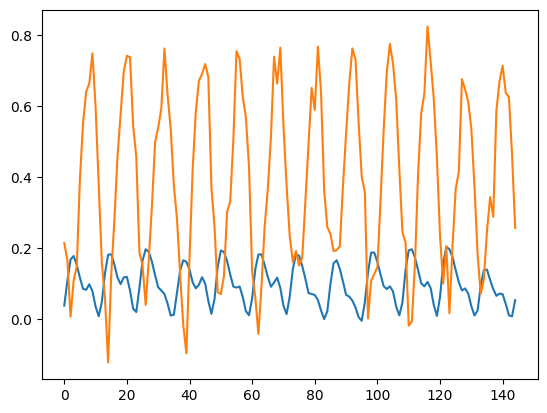

In [26]:
fig, ax = plt.subplots()
ax.plot(prediction)
ax.plot(target_test)

### Plot first 10 years of data against predictions